Okay first thing's first, let's get the prerequisites installed. Aerosandbox will provide the simulation environment, and baseline will include gym and the related requirements for training a model to optimize within that simulation.

🚨 Using Python 3.9.6 (3.11.x has compatability issues with AeroSandbox)

In [14]:
# # # Install a pip package in the current Jupyter kernel 🚨RUN THIS CELL ONCE FOR YOUR ENVIRONMENT
# import sys
# !"{sys.executable}" -m pip install "aerosandbox[full]"
# !"{sys.executable}" -m pip install "gymnasium[all]"
# !"{sys.executable}" -m pip install "stable_baselines3[extra]"
# !"{sys.executable}" -m pip install "tensorboard"

Alright let's set up the custom environment

First let's instantiate a plane with basic geometry:

In [21]:
#Helper
import random
import aerosandbox.numpy as np
def flatten_list(nested_item):
    flattened = []
    
    if isinstance(nested_item, (list, np.ndarray)):
        for item in nested_item:
            flattened.extend(flatten_list(item))
    else:
        flattened.append(nested_item)
    
    return flattened

def offsetsToLocations(offsets, minXGap):
    # Initialize an empty list to store the resulting locations
    locations = []
    # Initialize the starting location
    previous_location = [0, 0, 0]
    current_location = [0, 0, 0]
    
    # Iterate through each offset in the list
    for offset in offsets:
        locations.append(current_location.copy())
        previous_location = current_location.copy()
        current_location = [
            current_location[0] + offset[0],
            current_location[1] + offset[1],
            current_location[2] + offset[2],
        ]
        if(current_location[1] - previous_location[1] < minXGap):
            current_location[1] = previous_location[1] + minXGap
        
    
    return locations

def locationsToOffsets(locations):
    # Initialize an empty list to store the resulting offsets
    offsets = []
    
    # Initialize the previous location
    prev_location = [0, 0, 0]
    
    # Iterate through each location in the list
    for location in locations:
        # Calculate the offset as the difference between the current and previous locations
        offset = [location[i] - prev_location[i] for i in range(3)]
        
        # Append the offset to the list of offsets
        offsets.append(offset)
        
        # Update the previous location for the next iteration
        prev_location = location
    
    return offsets

In [30]:
import math
import aerosandbox as asb
import gymnasium as gym
from gymnasium import spaces
import numpy as np
	
class AeroEnv(gym.Env):

	# construct and save self.airplane from self.xsecs
	def constructAirplane(self):
		self.airplane = asb.Airplane(
			name="TestPlane",
			xyz_ref=[0, 0, 0],        # Reference for moments
			wings=[asb.Wing(
					name="Wing",    
					symmetric=False,
					xsecs=self.xsecs
				)],
		)
	
	#attempting to constraint reward
	def getReward(self):
		lift = self.aero["L"]
		drag = self.aero["D"]
		torque = self.aero["M_g"][2]

		#Low drag is great even if lift ends up being downforce.
		if(lift < 0):
			reward = 0
		else:
			reward = abs(lift/drag)

		#Minimize torque means a slimmer wing on its length
		torquePenalty = math.log(abs(self.aero["M_g"][2]),5)
		reward = reward - torquePenalty
		
		reward = reward*(self.currStep/self.episodeSteps)**2

		#Is torque sucking the wing forward magically? Drag? 0 reward.
		if(drag < 0 or self.aero["M_g"][2] > 0):
			reward = -50
		
		#final constraints, to prevent insanely negative rewards
		reward = max(reward, -50)
		reward = min(reward, 150)
		
		torqueStr = f"Torque on Z: {round(torque, 2)}"
		torqueStrLog = f"Torque Penalty: {round(torquePenalty, 2)}"
		liftStr = f"Lift: {round(lift, 3)}"
		dragStr = f"Drag: {round(drag, 3)}"
		lift_drag = f"Lift/Drag: {round(lift/drag,3)}"
		step = f"Step: {self.currStep}/{self.episodeSteps}"
		reward_str = f"Reward: {round(reward,3)}"

		output = "\n".join([torqueStr, torqueStrLog, liftStr, dragStr, lift_drag, step, reward_str])
		print(output)
		return reward

	# construct and safe self.vlm()
	def runAero(self):
		self.vlm = asb.VortexLatticeMethod(
			airplane=self.airplane,
			op_point=asb.OperatingPoint(
				velocity=22.22,  # 80kph
				alpha=0,  # degree
			),
		)
		# self.vlm.run_symmetric = True
		self.aero = self.vlm.run()
	
	def get_observation_vector(self):
		obs = []
		for xsec in self.xsecs:
			# xyz_le is a list of three values
			obs.extend(xsec.xyz_le)
			
			# chord and twist are single values
			obs.append(xsec.chord)
			obs.append(xsec.twist)

			# KulfanAirfoil attributes
			# Both upper_weights and lower_weights are numpy arrays
			obs.extend(xsec.airfoil.upper_weights.tolist())
			obs.extend(xsec.airfoil.lower_weights.tolist())

			# leading_edge_weight, N1, and N2 are single values
			obs.append(xsec.airfoil.leading_edge_weight)
			obs.append(xsec.airfoil.N1)
			obs.append(xsec.airfoil.N2)
		# Append aerodynamics output at the end
		# - 'F_g' : an [x, y, z] list of forces in geometry axes [N]
		# - 'F_b' : an [x, y, z] list of forces in body axes [N]
		# - 'F_w' : an [x, y, z] list of forces in wind axes [N]
		# - 'M_g' : an [x, y, z] list of moments about geometry axes [Nm]
		# - 'M_b' : an [x, y, z] list of moments about body axes [Nm]
		# - 'M_w' : an [x, y, z] list of moments about wind axes [Nm]
		# - 'L' : the lift force [N]. Definitionally, this is in wind axes.
		# - 'Y' : the side force [N]. This is in wind axes.
		# - 'D' : the drag force [N]. Definitionally, this is in wind axes.
		# - 'l_b', the rolling moment, in body axes [Nm]. Positive is roll-right.
		# - 'm_b', the pitching moment, in body axes [Nm]. Positive is pitch-up.
		# - 'n_b', the yawing moment, in body axes [Nm]. Positive is nose-right.
		# - 'CL', the lift coefficient [-]. Definitionally, this is in wind axes.
		# - 'CY', the sideforce coefficient [-]. This is in wind axes.
		# - 'CD', the drag coefficient [-]. Definitionally, this is in wind axes.
		# - 'Cl', the rolling coefficient [-], in body axes
		# - 'Cm', the pitching coefficient [-], in body axes
		# - 'Cn', the yawing coefficient [-], in body axes
		drag = self.aero["D"]
		lift = self.aero["L"]
		drag = np.tanh((drag-50)/50)
		lift = np.tanh((lift-50)/50)
		obs.append(lift)
		obs.append(drag)
		obs.append(self.currStep)
		return np.array(obs, dtype=np.float32)
	
	def __init__(self, 
			  # === Key Parameters ===
			  episodeSteps,
			  kulfanWeightResolution, 	#How many kulfan weights per XSec? More = more intricate designs. Something like 5-8 should be enough...
			  numChords, 				#How many independently controlled foils along length of wing 
			  minChordSpacing,
			  minChordLength,

			  # === Initial Values ===
			  initialYSpacing, 			#Initial spacing of the cross sections
			  initialChordLength, 		#Initial length from front to back of each cross section in wing
			  initialUpperKulfan, 		#Upper kulfan weight initial values (controls curvature of top of wing)
			  initialLowerKulfan, 		#Lower Kulfan weight initial values (controls curvature of bottom of wing)
			  initialLEW, 				#Leading edge weight initial values
			  initialN1, 				#Initial N1 value (forward shift of wing curve shape)
			  initialN2, 				#Initial N2 value (backwards shift of wing curve shape)
			  
			  # === Changing Values ===
			  dX_bounds, 				#How much to allow shift of each cross section per time step in forward/backwards direction
			  dY_bounds, 				#How much to allow shift of each cross section per time step in left/right direction (stubbier wings)
			  dZ_bounds, 				#How much to allow shift of each cross section per time step in up/down direction (wingtips?)
			  dChord_bounds, 			#How much to allow each cross section to change in length per timestep (wider wings? front-back length)
			  dTwist_bounds, 			#How much (in DEGREES) to allow rotation of each cross section per timestep about leading edge
			  KT_bounds, 				#Min/max upper kulfan weights (should be 0,>0)
			  KB_bounds, 				#Max lower kulfan weights (should be <0,0 unless you want to create gaps on bottom of wing that arc up)
			  N_bounds, 				#Bounds of either N value (1, ?)
			  LEW_bounds, 				#Bounds of leading edge weight (??? TODO: Learn what the fuck this does lmao. Experiment)
		):
		super(AeroEnv, self).__init__() #Initialize gym enviro
		self.numChords = numChords
		self.kulfanWeightResolution = kulfanWeightResolution
		self.minChordSpacing = minChordSpacing
		self.minChordLength = minChordLength
		self.episodeSteps = episodeSteps
		
		# Lower and upper bounds for each of the parameters
		low = np.array([dX_bounds[0], dY_bounds[0], dZ_bounds[0], dChord_bounds[0], dTwist_bounds[0]] + [KT_bounds[0]]*kulfanWeightResolution + [KB_bounds[0]]*kulfanWeightResolution + [N_bounds[0], N_bounds[0], LEW_bounds[0]], dtype=np.float32)
		high = np.array([dX_bounds[1], dY_bounds[1], dZ_bounds[1], dChord_bounds[1], dTwist_bounds[1]] + [KT_bounds[1]]*kulfanWeightResolution + [KB_bounds[1]]*kulfanWeightResolution + [N_bounds[1], N_bounds[1], LEW_bounds[1]], dtype=np.float32)
		self.vectorLengthPerXSec = len(low)
		# Creates a much bigger vector, action bounds PER cross section.
		oLow = low.copy()
		oHigh = high.copy()
		low = np.tile(low, numChords) 
		high = np.tile(high, numChords)

		# === Establish bounds for leading edges === 
		oLow[0]=oLow[0]*episodeSteps + 0 # 0 here is the initial value min
		oLow[1]=0 # 0 here is the initial value min
		oLow[2]=oLow[2]*episodeSteps + 0 # 0 here is the initial value min

		oHigh[0]=oHigh[0]*episodeSteps + 0 # 0 here is the initial value max
		oHigh[1]=oHigh[1]*episodeSteps*numChords # initial value max is gonna be the farthest chord out
		oHigh[2]=oHigh[2]*episodeSteps + 0 # 0 here is the initial value max

		# === Establish bounds for CHORD and TWIST === 
		oLow[3]=oLow[3]*episodeSteps + initialChordLength 
		oLow[4]=oLow[4]*episodeSteps + 0 

		oHigh[3]=oHigh[3]*episodeSteps + initialChordLength
		oHigh[4]=oHigh[4]*episodeSteps + 0

		# === Establish KT / KB weight bounds, N bounds, LEW bounds ===
		# No need because absolute value, so bounds are same as action bounds

		oLow = np.tile(oLow, numChords) 
		oHigh = np.tile(oHigh, numChords)

		# === Establish Aerodynamic Bounds (AFTER tiling because not 1 per chord) ===
		oLow = np.append(oLow, [-1, -1]) #Lift, Drag: I intend to use tanH
		oHigh = np.append(oHigh, [1, 1]) #Lift, Drag: I intend to use tanH		

		# === Establish Episode Bounds (AFTER tiling because not 1 per chord) ===
		oLow = np.append(oLow, 0) 
		oHigh = np.append(oHigh, episodeSteps) 	

		self.observation_space = spaces.Box(low=oLow, high=oHigh, dtype=np.float32) #there are 18 additional values provided by vlm.run(), but Im just using 2, Lift and Drag
		self.action_space = spaces.Box(low=low, high=high, dtype=np.float32)
		

		# Initial values for cross sections
		self.init_xyz_le_offsets = [[0, initialYSpacing, 0]]*self.numChords
		self.init_chord = [initialChordLength] * self.numChords  														
		self.init_twist = [0] * self.numChords  														
		self.init_upper_weights = [np.array([initialUpperKulfan] * self.kulfanWeightResolution,np.float32) for _ in range(self.numChords)]
		self.init_lower_weights = [np.array([initialLowerKulfan] * self.kulfanWeightResolution,np.float32) for _ in range(self.numChords)]
		self.init_leading_edge_weight = [initialLEW] * self.numChords  										
		self.init_N1 = [initialN1] * self.numChords 															
		self.init_N2 = [initialN2] * self.numChords


		self.init_xyz_le = offsetsToLocations(self.init_xyz_le_offsets, minXGap=self.minChordSpacing)
		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i],
			)
		) for i in range(self.numChords)]
		self.constructAirplane()
		self.currStep = 0
		
	def step(self, action):
		self.currStep += 1
		#Turn chord positions into offsets
		currPos=[]
		for i in range(self.numChords):
			# Apply dX, dY, dZ
			currPos.append([
				self.xsecs[i].xyz_le[0],
				self.xsecs[i].xyz_le[1],
				self.xsecs[i].xyz_le[2]
			])
		
		offsets = locationsToOffsets(currPos)
		for i in range(self.numChords):
			idx = i * self.vectorLengthPerXSec
			# Apply dX, dY, dZ
			offsets[i] = [
				offsets[i][0] + action[idx], 		#x + dx
				offsets[i][1] + action[idx + 1],	#y + dy
				offsets[i][2] + action[idx + 2]		#z + dz
			]
		
		newXYZ_le_positions = offsetsToLocations(offsets, minXGap=self.minChordSpacing)

		for i in range(self.numChords):
			idx = i * self.vectorLengthPerXSec
			newXYZ_le = newXYZ_le_positions[i]
			# Apply dChord, dTwist
			newChord = self.xsecs[i].chord + action[idx + 3] #chord + dchord
			newTwist = self.xsecs[i].twist + action[idx + 4]

			# Set KB, KT 
			newUpper_weights = np.array([action[idx + 5 + j] for j in range(self.kulfanWeightResolution)], np.float32)
			newLower_weights = np.array([action[idx + 5+self.kulfanWeightResolution + j] for j in range(self.kulfanWeightResolution)], np.float32)
			
			# Set LEW, N1, N2
			newLeading_edge_weight = action[idx + 5+2*self.kulfanWeightResolution] 	# LEW = action's LEW
			newN1 = action[idx + 6+2*self.kulfanWeightResolution] 					# N1 = action's N1
			newN2 = action[idx + 7+2*self.kulfanWeightResolution]					# N2 = action's N2

			self.xsecs[i] = asb.WingXSec(
				xyz_le=([0,0,0] if i == 0 else newXYZ_le), #might not be needed
				chord=max(newChord, self.minChordLength),
				twist=newTwist,
				airfoil=asb.KulfanAirfoil(
					leading_edge_weight=newLeading_edge_weight,
					lower_weights=newLower_weights,
					upper_weights=newUpper_weights,
					N1=newN1,
					N2=newN2
				)
			)

		self.constructAirplane()
		self.runAero()
		
		obs = self.get_observation_vector()				# observation (ObsType): An element of the environment's observation_space as the next observation due to the agent actions.
		reward = self.getReward()						# reward (SupportsFloat): The reward as a result of taking the action.
		terminated = self.currStep == self.episodeSteps	# terminated (bool): Whether the agent reaches the terminal state (as defined under the MDP of the task)
		truncated = False	 							# truncated (bool): Whether the truncation condition outside the scope of the MDP is satisfied.
		info = {"lift": self.aero["L"], "drag": self.aero["L"]}	# info (dict): Contains auxiliary diagnostic information (helpful for debugging, learning, and logging).
		
		return obs, reward, terminated, truncated, info 
    
	def reset(self, seed=random.randint(1, 9999)):
		super().reset(seed=seed)
		print("Reset was called!")
		self.currStep = 0
		# Reinitialize wing sections to their initial states
		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(self.numChords)]

		randomAction = self.action_space.sample()
		self.step(randomAction)

		self.constructAirplane()
		self.runAero()
		
		liftCoeff = self.aero["CL"]
		dragCoeff = self.aero["CD"]

		obs = self.get_observation_vector()
		info = {"lift": liftCoeff, "drag": dragCoeff} 
		return obs, info
	
	def render(self):
		self.runAero()
		self.airplane.draw_three_view()
		# self.vlm.draw()
	
	def close (self):
		...

In [36]:
steps = 5 #steps per episode used in model training before resetting
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv

def make_env():
    def _init():
        env = AeroEnv(
            episodeSteps=steps,
            numChords=3, 
            minChordLength=0.2,
            minChordSpacing=0.3,
            initialYSpacing=1, 
            initialChordLength=1, 
            initialUpperKulfan=1, 
            initialLowerKulfan=-0.3, 
            initialLEW=0.1, 
            initialN1=1, 
            initialN2=1, 
            dX_bounds = (-1, 1),
            dY_bounds = (-2, 2),
            dZ_bounds = (0, 0),
            dChord_bounds = (-0.5, 0.5),
            dTwist_bounds = (-5, 5),
            KT_bounds = (0, 1),
            KB_bounds = (-1, 0),
            N_bounds = (1, 3),
            LEW_bounds = (0, 0.6),
            kulfanWeightResolution = 5
        )
        env = DummyVecEnv([lambda:env])
        return env
    return _init

In [37]:
# ##SanityCheck

env = make_env()()

obs = env.reset()
env.render()

random_action = env.action_space.sample()
env.step(random_action)
env.render()

random_action = env.action_space.sample()
env.step(random_action)
env.render()

random_action = env.action_space.sample()
env.step(random_action)
env.render()

random_action = env.action_space.sample()
env.step(random_action)
env.render()

random_action = env.action_space.sample()
env.step(random_action)
env.render()


Reset was called!
Torque on Z: -616.41
Torque Penalty: 3.99
Lift: -11.75
Drag: 1764.355
Lift/Drag: -0.007
Step: 1/5
Reward: -0.16


IndexError: invalid index to scalar variable.

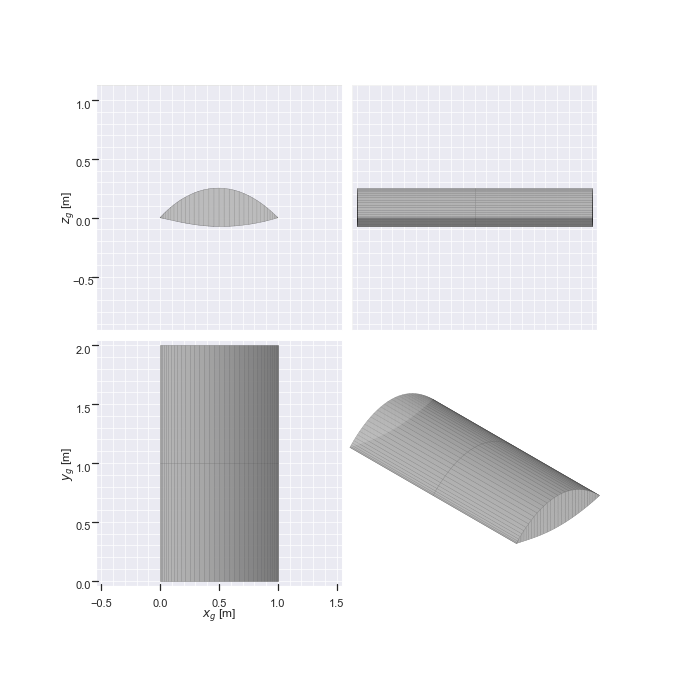

Reset was called!
Torque on Z: -806.0
Torque Penalty: 4.16
Lift: -592.667
Drag: 685.975
Lift/Drag: -0.864
Step: 1/5
Reward: -0.166
Torque on Z: -817203014.41
Torque Penalty: 12.75
Lift: -425917424.171
Drag: 336042285.474
Lift/Drag: -1.267
Step: 2/5
Reward: -2.04
Torque on Z: -44.11
Torque Penalty: 2.35
Lift: -96.245
Drag: 37.053
Lift/Drag: -2.597
Step: 3/5
Reward: -0.847
Torque on Z: -11.95
Torque Penalty: 1.54
Lift: -19.704
Drag: 21.09
Lift/Drag: -0.934
Step: 4/5
Reward: -0.986
Torque on Z: -57841.81
Torque Penalty: 6.81
Lift: 8589.785
Drag: 16183.602
Lift/Drag: 0.531
Step: 5/5
Reward: -6.282
Reset was called!
Torque on Z: -95.7
Torque Penalty: 2.83
Lift: 216.31
Drag: 44.184
Lift/Drag: 4.896
Step: 1/5
Reward: 0.082
Torque on Z: -3748.89
Torque Penalty: 5.11
Lift: -270.407
Drag: 1285.716
Lift/Drag: -0.21
Step: 2/5
Reward: -0.818
Torque on Z: -490.26
Torque Penalty: 3.85
Lift: -297.654
Drag: 1005.738
Lift/Drag: -0.296
Step: 3/5
Reward: -1.386
Torque on Z: -94677065.42
Torque Penalty: 11

In [19]:
from stable_baselines3 import PPO
import os
import time
# from stable_baselines3.common.callbacks import EvalCallback
# from stable_baselines3.common.vec_env import DummyVecEnv
# from stable_baselines3.common.vec_env import VecNormalize
import copy

models_dir = f"models/A2C-{int(time.time())}"
logdir = f"logs/A2C-{int(time.time())}"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

# envs = [make_env() for _ in range(3)]
# env = DummyVecEnv(envs)
# env = VecNormalize(env)
env = make_env()()
# evalEnv = copy.deepcopy(env)
# eval_callback = EvalCallback(
#     eval_env=evalEnv, 
#     best_model_save_path='./logs/best_model/',
#     log_path='./logs/eval_log/', 
#     eval_freq=1000)

# TODO: find a way to use eval callback that doesnt add 10 minutes per eval to the run

model = PPO(
	n_steps=steps,
    batch_size=steps,
	policy="MlpPolicy",
	env=env,
    n_epochs=10,
    learning_rate=.0003,
	verbose=0,
    tensorboard_log=logdir,
    stats_window_size=steps,
)

env.render()

total_timesteps = 3000
model.learn(total_timesteps=total_timesteps)

print("We lerned")

Reset was called!


Torque on Z: -161640270.24
Torque Penalty: 11.74
Lift: -26929659.698
Drag: 85789771.503
Lift/Drag: -0.314
Step: 1/5
Reward: -0.47
0
Torque on Z: -66.1
Torque Penalty: 2.6
Lift: 468.703
Drag: 15.396
Lift/Drag: 30.443
Step: 2/5
Reward: 4.454
1
Torque on Z: -12.73
Torque Penalty: 1.58
Lift: 290.045
Drag: 2.865
Lift/Drag: 101.233
Step: 3/5
Reward: 35.875
2
Torque on Z: -29.22
Torque Penalty: 2.1
Lift: 531.775
Drag: 8.805
Lift/Drag: 60.392
Step: 4/5
Reward: 37.309
3
Torque on Z: -6.23
Torque Penalty: 1.14
Lift: 195.516
Drag: 2.493
Lift/Drag: 78.427
Step: 5/5
Reward: 77.29
4
Torque on Z: -16.69
Torque Penalty: 1.75
Lift: 360.392
Drag: 6.074
Lift/Drag: 59.332
Step: 6/5
Reward: 82.92
===






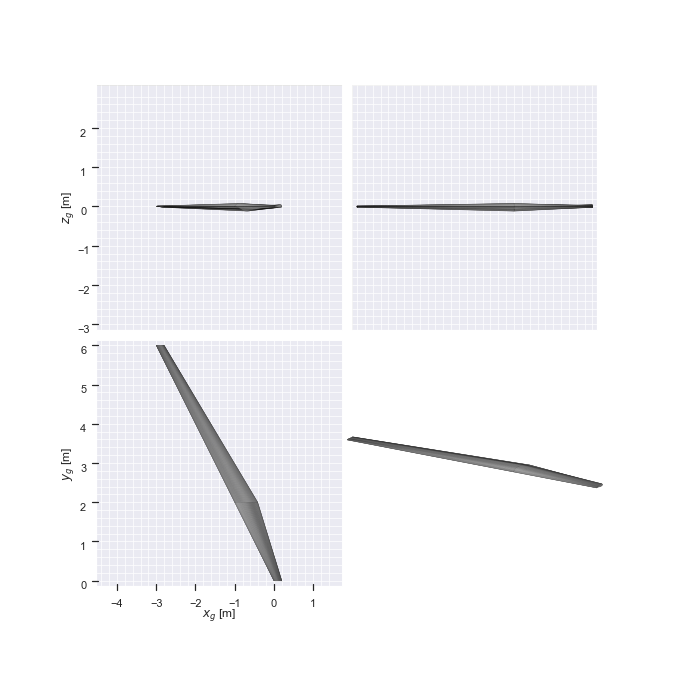

Reset was called!
Torque on Z: -1325269787.18
Torque Penalty: 13.05
Lift: 49930797.275
Drag: 2277567741.824
Lift/Drag: 0.022
Step: 1/5
Reward: -0.521
Reset was called!
Torque on Z: -495067.56
Torque Penalty: 8.15
Lift: 19831.359
Drag: 498980.903
Lift/Drag: 0.04
Step: 1/5
Reward: -0.324
0
Torque on Z: -11.29
Torque Penalty: 1.51
Lift: 3.654
Drag: 3.783
Lift/Drag: 0.966
Step: 2/5
Reward: -0.086
1
Torque on Z: -1.45
Torque Penalty: 0.23
Lift: 42.741
Drag: 0.548
Lift/Drag: 78.051
Step: 3/5
Reward: 28.016
2
Torque on Z: -2.51
Torque Penalty: 0.57
Lift: 178.686
Drag: 1.166
Lift/Drag: 153.216
Step: 4/5
Reward: 97.693
3
Torque on Z: -0.35
Torque Penalty: -0.65
Lift: 69.383
Drag: 0.26
Lift/Drag: 266.618
Step: 5/5
Reward: 150
4
Torque on Z: -1.78
Torque Penalty: 0.36
Lift: 130.572
Drag: 2.693
Lift/Drag: 48.484
Step: 6/5
Reward: 69.299
===






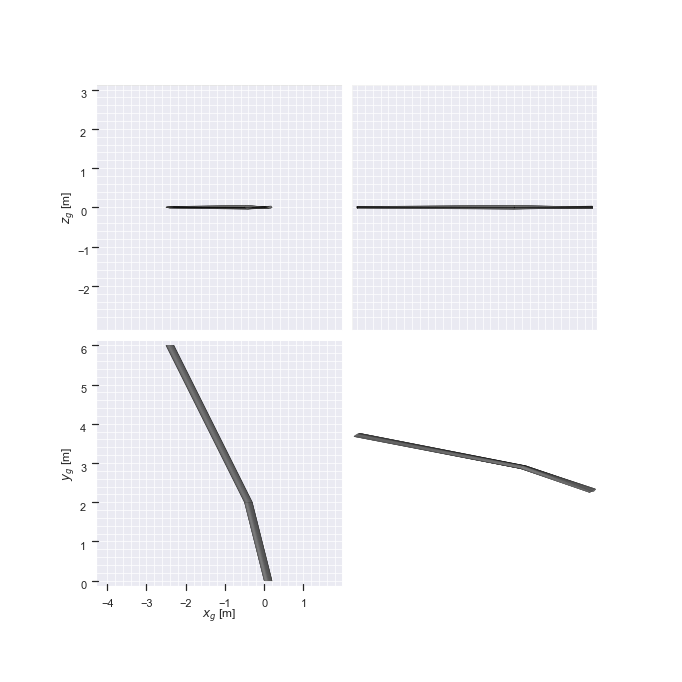

Reset was called!
Torque on Z: -40650.64
Torque Penalty: 6.59
Lift: 2117.417
Drag: 11591.743
Lift/Drag: 0.183
Step: 1/5
Reward: -0.256
Reset was called!
Torque on Z: 47059.13
Torque Penalty: 6.69
Lift: -25165.094
Drag: 274746.755
Lift/Drag: -0.092
Step: 1/5
Reward: -50
0
Torque on Z: -91.81
Torque Penalty: 2.81
Lift: 499.955
Drag: 37.086
Lift/Drag: 13.481
Step: 2/5
Reward: 1.708
1
Torque on Z: -8.98
Torque Penalty: 1.36
Lift: 426.54
Drag: 11.219
Lift/Drag: 38.02
Step: 3/5
Reward: 13.196
2
Torque on Z: -13.11
Torque Penalty: 1.6
Lift: 286.422
Drag: 3.178
Lift/Drag: 90.115
Step: 4/5
Reward: 56.65
3
Torque on Z: -7.36
Torque Penalty: 1.24
Lift: 196.934
Drag: 1.461
Lift/Drag: 134.839
Step: 5/5
Reward: 133.599
4
Torque on Z: -6.84
Torque Penalty: 1.19
Lift: 252.216
Drag: 2.442
Lift/Drag: 103.263
Step: 6/5
Reward: 146.979
===






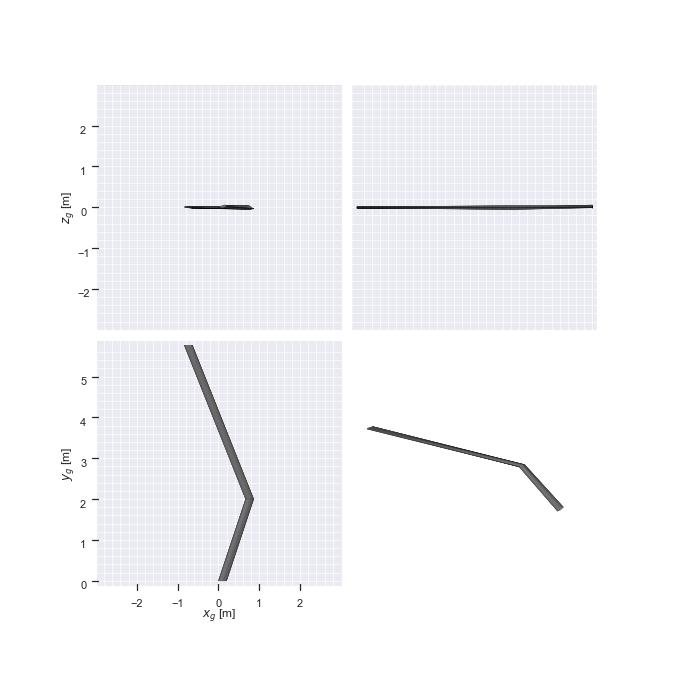

Reset was called!
Torque on Z: -3867.93
Torque Penalty: 5.13
Lift: 359.484
Drag: 902.82
Lift/Drag: 0.398
Step: 1/5
Reward: -0.189
Reset was called!
Torque on Z: -16743502737.82
Torque Penalty: 14.63
Lift: 5267271451.328
Drag: 5337382630.516
Lift/Drag: 0.987
Step: 1/5
Reward: -0.546
0
Torque on Z: -0.37
Torque Penalty: -0.62
Lift: 16.61
Drag: 0.145
Lift/Drag: 114.544
Step: 2/5
Reward: 18.426
1
Torque on Z: -2.66
Torque Penalty: 0.61
Lift: 44.352
Drag: 0.819
Lift/Drag: 54.127
Step: 3/5
Reward: 19.267
2
Torque on Z: -0.7
Torque Penalty: -0.22
Lift: 65.132
Drag: 0.627
Lift/Drag: 103.877
Step: 4/5
Reward: 66.621
3
Torque on Z: -2.79
Torque Penalty: 0.64
Lift: 162.171
Drag: 1.189
Lift/Drag: 136.381
Step: 5/5
Reward: 135.742
4
Torque on Z: -4.19
Torque Penalty: 0.89
Lift: 151.48
Drag: 0.956
Lift/Drag: 158.493
Step: 6/5
Reward: 150
===






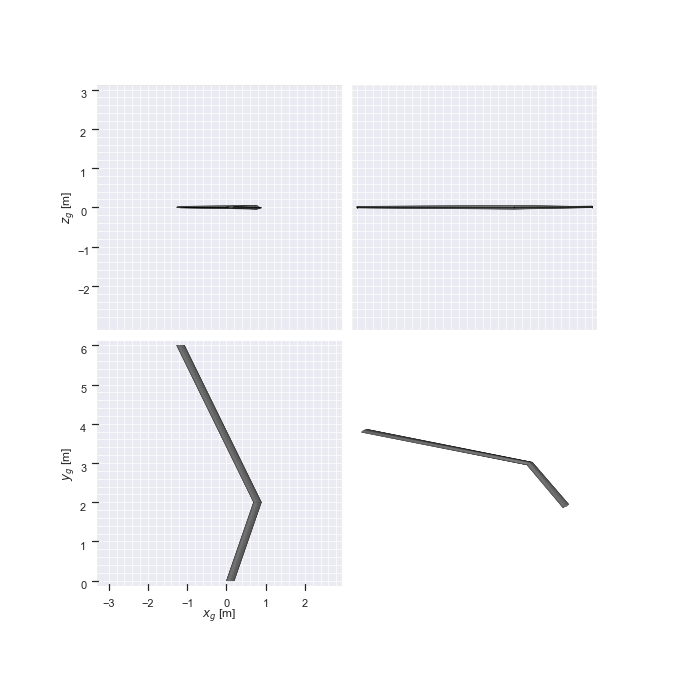

Reset was called!
Torque on Z: -1193968.37
Torque Penalty: 8.69
Lift: -135037.349
Drag: 4666131.284
Lift/Drag: -0.029
Step: 1/5
Reward: -0.348
Reset was called!
Torque on Z: -396.99
Torque Penalty: 3.72
Lift: -256.195
Drag: 462.289
Lift/Drag: -0.554
Step: 1/5
Reward: -0.149
0
Torque on Z: -22.02
Torque Penalty: 1.92
Lift: 316.906
Drag: 9.134
Lift/Drag: 34.694
Step: 2/5
Reward: 5.244
1
Torque on Z: -139.07
Torque Penalty: 3.07
Lift: 723.862
Drag: 30.556
Lift/Drag: 23.689
Step: 3/5
Reward: 7.424
2
Torque on Z: -189.88
Torque Penalty: 3.26
Lift: 1417.15
Drag: 75.926
Lift/Drag: 18.665
Step: 4/5
Reward: 9.859
3
Torque on Z: -25.82
Torque Penalty: 2.02
Lift: 539.605
Drag: 8.391
Lift/Drag: 64.306
Step: 5/5
Reward: 62.286
4
Torque on Z: -18.5
Torque Penalty: 1.81
Lift: 343.319
Drag: 4.108
Lift/Drag: 83.579
Step: 6/5
Reward: 117.744
===






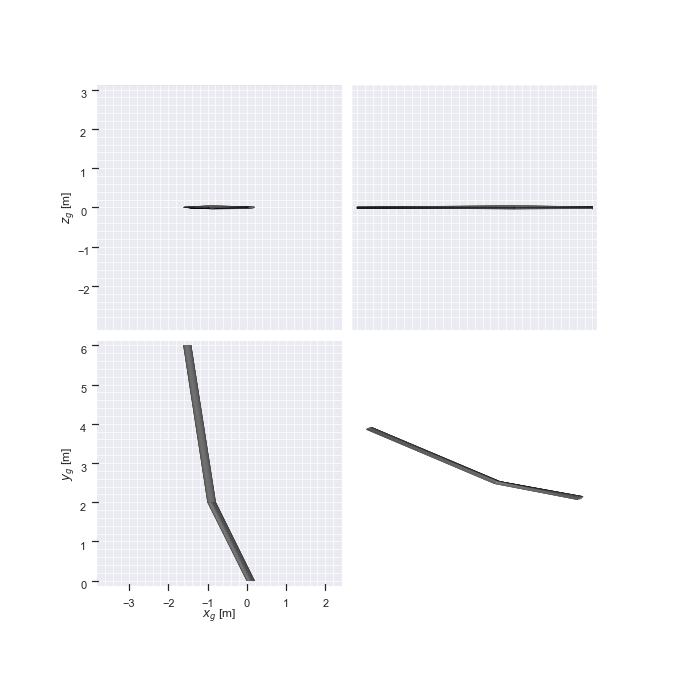

Reset was called!
Torque on Z: -2626.8
Torque Penalty: 4.89
Lift: 412.322
Drag: 3194.276
Lift/Drag: 0.129
Step: 1/5
Reward: -0.191
Reset was called!
Torque on Z: -3046811851.01
Torque Penalty: 13.57
Lift: 106636236.096
Drag: 2516885548.306
Lift/Drag: 0.042
Step: 1/5
Reward: -0.541
0
Torque on Z: -11.51
Torque Penalty: 1.52
Lift: 10.079
Drag: 3.06
Lift/Drag: 3.294
Step: 2/5
Reward: 0.284
1
Torque on Z: -7.29
Torque Penalty: 1.23
Lift: -29.481
Drag: 0.885
Lift/Drag: -33.314
Step: 3/5
Reward: -0.444
2
Torque on Z: -64.88
Torque Penalty: 2.59
Lift: 782.825
Drag: 23.254
Lift/Drag: 33.663
Step: 4/5
Reward: 19.885
3
Torque on Z: -3.87
Torque Penalty: 0.84
Lift: 77.853
Drag: 1.891
Lift/Drag: 41.177
Step: 5/5
Reward: 40.337
4
Torque on Z: -0.56
Torque Penalty: -0.36
Lift: 62.478
Drag: 0.175
Lift/Drag: 357.485
Step: 6/5
Reward: 150
===






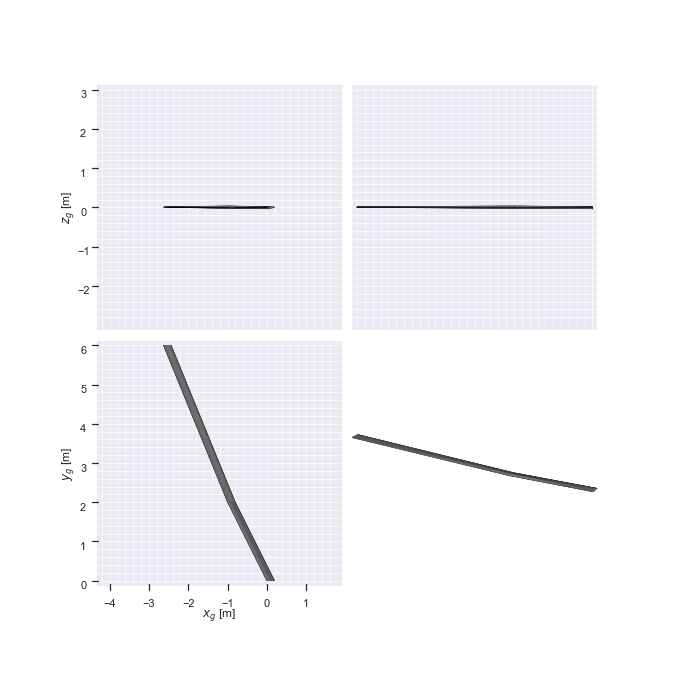

Reset was called!
Torque on Z: -688.42
Torque Penalty: 4.06
Lift: 349.605
Drag: 4580.623
Lift/Drag: 0.076
Step: 1/5
Reward: -0.159
Reset was called!
Torque on Z: -645330.21
Torque Penalty: 8.31
Lift: -423675.06
Drag: 394224.541
Lift/Drag: -1.075
Step: 1/5
Reward: -0.332
0
Torque on Z: -7.56
Torque Penalty: 1.26
Lift: 142.57
Drag: 3.402
Lift/Drag: 41.902
Step: 2/5
Reward: 6.503
1
Torque on Z: -1.36
Torque Penalty: 0.19
Lift: 97.146
Drag: 1.731
Lift/Drag: 56.124
Step: 3/5
Reward: 20.136
2
Torque on Z: -1.56
Torque Penalty: 0.28
Lift: 108.724
Drag: 1.506
Lift/Drag: 72.176
Step: 4/5
Reward: 46.017
3
Torque on Z: -4.68
Torque Penalty: 0.96
Lift: 209.045
Drag: 3.605
Lift/Drag: 57.991
Step: 5/5
Reward: 57.033
4
Torque on Z: -4.83
Torque Penalty: 0.98
Lift: 216.493
Drag: 1.351
Lift/Drag: 160.204
Step: 6/5
Reward: 150
===






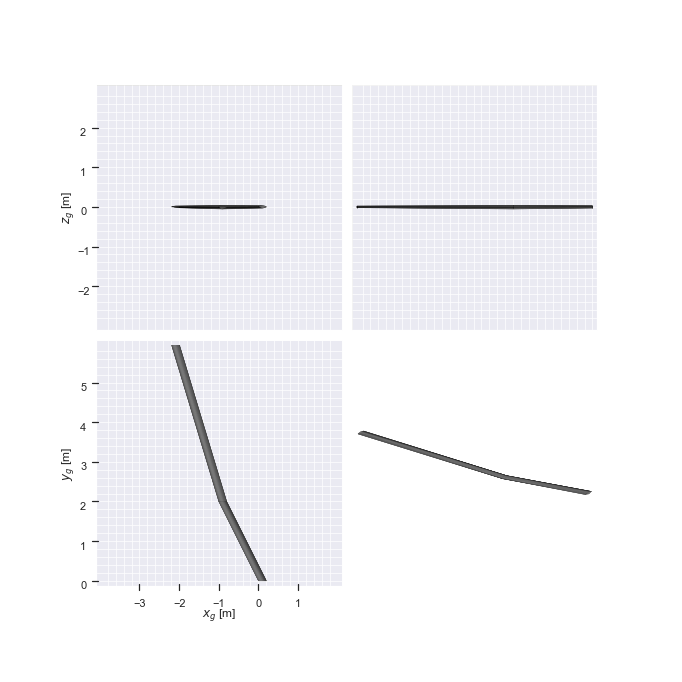

Reset was called!
Torque on Z: -86938.76
Torque Penalty: 7.07
Lift: -15843.721
Drag: 46063.562
Lift/Drag: -0.344
Step: 1/5
Reward: -0.283
Reset was called!
Torque on Z: -17522691140.3
Torque Penalty: 14.66
Lift: 9452922045.934
Drag: 8376927100.371
Lift/Drag: 1.128
Step: 1/5
Reward: -0.541
0
Torque on Z: -26.85
Torque Penalty: 2.04
Lift: 348.363
Drag: 9.664
Lift/Drag: 36.048
Step: 2/5
Reward: 5.441
1
Torque on Z: -9.35
Torque Penalty: 1.39
Lift: 292.643
Drag: 4.334
Lift/Drag: 67.525
Step: 3/5
Reward: 23.809
2
Torque on Z: -15.85
Torque Penalty: 1.72
Lift: 362.792
Drag: 4.851
Lift/Drag: 74.789
Step: 4/5
Reward: 46.767
3
Torque on Z: -3.53
Torque Penalty: 0.78
Lift: 194.689
Drag: 1.367
Lift/Drag: 142.402
Step: 5/5
Reward: 141.617
4
Torque on Z: -18.99
Torque Penalty: 1.83
Lift: 392.858
Drag: 6.973
Lift/Drag: 56.344
Step: 6/5
Reward: 78.501
===






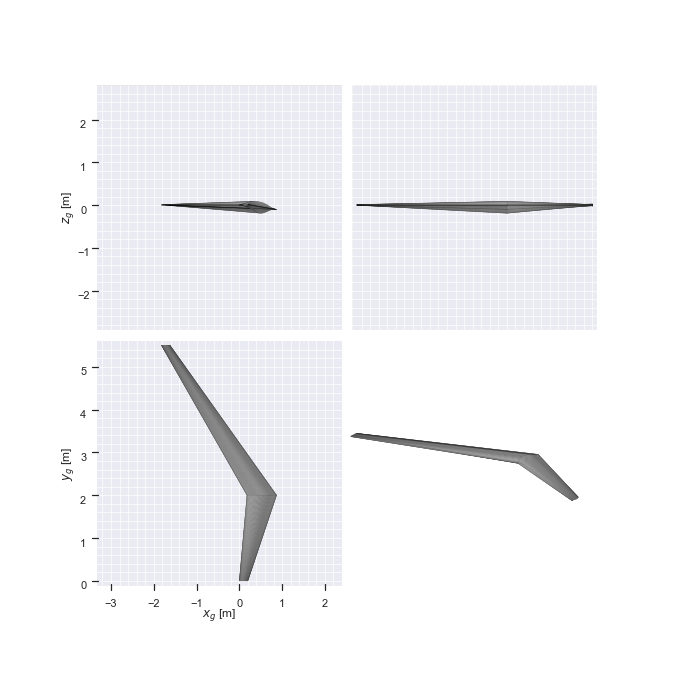

Reset was called!
Torque on Z: -3402510.3
Torque Penalty: 9.34
Lift: 610098.981
Drag: 654098.611
Lift/Drag: 0.933
Step: 1/5
Reward: -0.336
Reset was called!
Torque on Z: -79.66
Torque Penalty: 2.72
Lift: -174.811
Drag: 39.854
Lift/Drag: -4.386
Step: 1/5
Reward: -0.109
0
Torque on Z: -43.17
Torque Penalty: 2.34
Lift: 482.935
Drag: 10.877
Lift/Drag: 44.402
Step: 2/5
Reward: 6.73
1
Torque on Z: -11.37
Torque Penalty: 1.51
Lift: 63.712
Drag: 1.615
Lift/Drag: 39.457
Step: 3/5
Reward: 13.661
2
Torque on Z: -6.95
Torque Penalty: 1.2
Lift: 184.792
Drag: 1.428
Lift/Drag: 129.386
Step: 4/5
Reward: 82.036
3
Torque on Z: -5.03
Torque Penalty: 1.0
Lift: 131.495
Drag: 0.85
Lift/Drag: 154.664
Step: 5/5
Reward: 150
4
Torque on Z: -3.01
Torque Penalty: 0.68
Lift: 93.611
Drag: 0.525
Lift/Drag: 178.437
Step: 6/5
Reward: 150
===






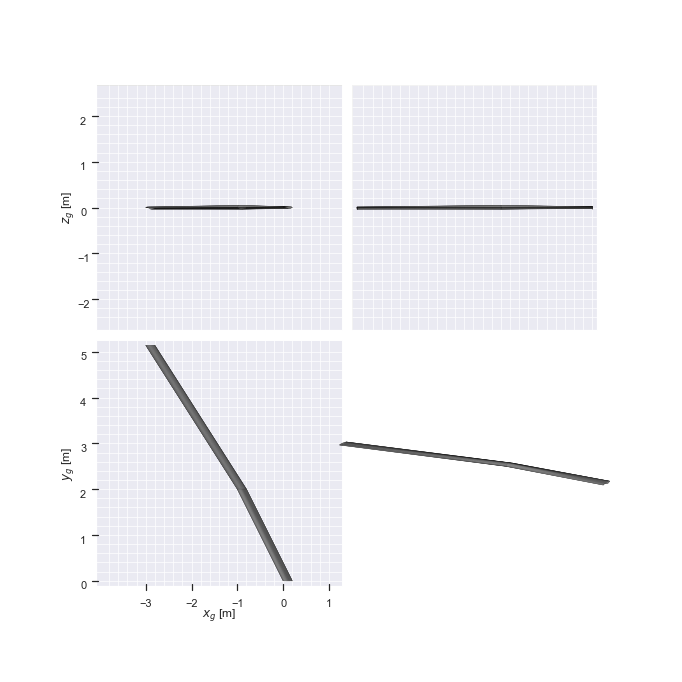

Reset was called!
Torque on Z: -119072.09
Torque Penalty: 7.26
Lift: 38735.679
Drag: 66578.193
Lift/Drag: 0.582
Step: 1/5
Reward: -0.267
Reset was called!
Torque on Z: -33762.88
Torque Penalty: 6.48
Lift: -41.711
Drag: 9179.308
Lift/Drag: -0.005
Step: 1/5
Reward: -0.259
0
Torque on Z: -22.26
Torque Penalty: 1.93
Lift: 483.687
Drag: 15.459
Lift/Drag: 31.288
Step: 2/5
Reward: 4.698
1
Torque on Z: -31.01
Torque Penalty: 2.13
Lift: 396.964
Drag: 13.36
Lift/Drag: 29.712
Step: 3/5
Reward: 9.928
2
Torque on Z: -4.65
Torque Penalty: 0.96
Lift: 194.771
Drag: 1.764
Lift/Drag: 110.41
Step: 4/5
Reward: 70.051
3
Torque on Z: -6.21
Torque Penalty: 1.13
Lift: 145.809
Drag: 1.675
Lift/Drag: 87.062
Step: 5/5
Reward: 85.928
4
Torque on Z: -36.43
Torque Penalty: 2.23
Lift: 492.903
Drag: 13.675
Lift/Drag: 36.044
Step: 6/5
Reward: 48.686
===






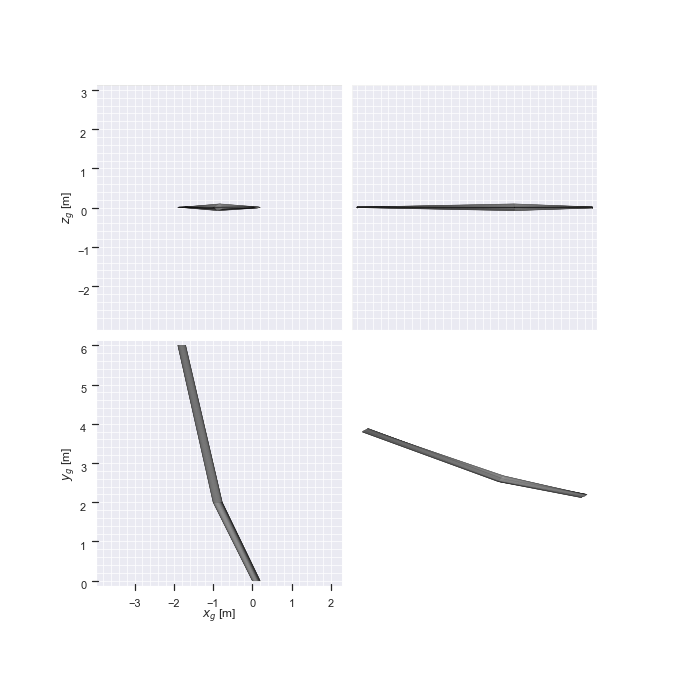

Reset was called!
Torque on Z: -10795966.9
Torque Penalty: 10.06
Lift: 116209418.141
Drag: 88651984.686
Lift/Drag: 1.311
Step: 1/5
Reward: -0.35


In [20]:
num_episodes = 10
for _ in range(num_episodes):
    obs, info = env.reset()
    terminated = False
    for i in range(0,steps):
        print(i)
        action, nextHiddenState = model.predict(obs)
        obs, rewards, terminated, truncated, info = env.step(action)
        # if(i%5 == 0):
        #     env.render()
    
    print("===\n\n\n\n")
    env.render()
    env.reset()
env.close()